### 프로젝트 개요
#### 프로젝트 명: 반려견 소변 분석 챗봇(PoC)
- 반려견의 고령화(9이상 고령견 43%)로 만성질환 특히 내분비 질환(당뇨, 고혈압 등) 증가
- Pet Humanization으로 반려동물도 인간 대접을 하고 있으나 정작 건강관리는 소홀
- 반려견의 내과 질환을 판단하기 가장 간편한 방법으로 배변패드에서 스마트 폰으로 검사하고 그 결과를 LLM으로 건강상태를 분석하는 서비스 PoC

#### PoC 내용
- 소변(pH)검사를 위한 pH 4(강산성) ~ pH 10(알카리성)을 분류하는 모델(EffientNet.v2 파인튜닝)
- LangChain을 이용한 간단한 챗봇 구현
- 향후 수의 상담을 지원하는 RAG기반 멀티모달 Agentic AI 개발 예정(MVP)

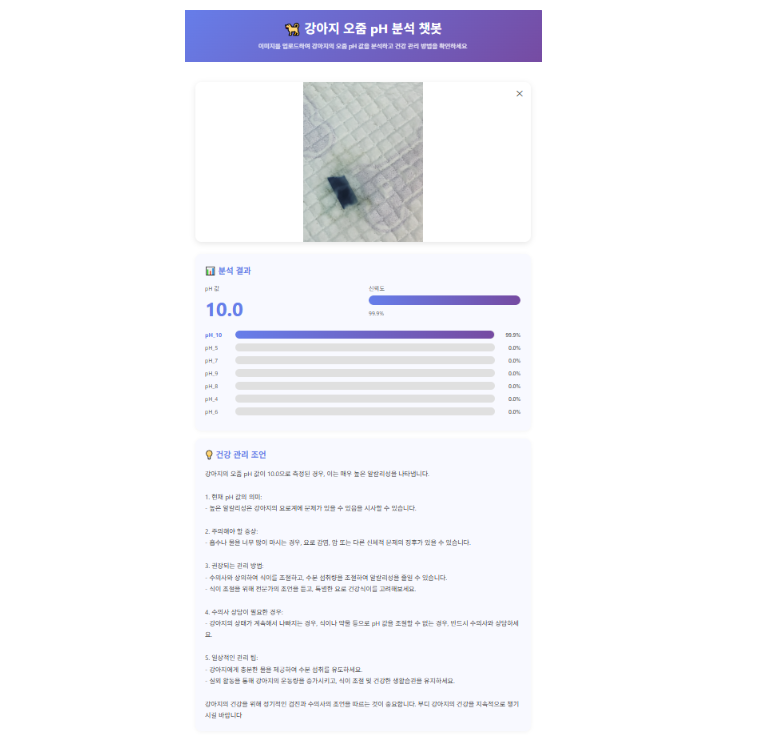

#### 데이터 개발 요약

- PoC 개발을 위하여 pH 4 ~ pH 10 의 데이터 개발

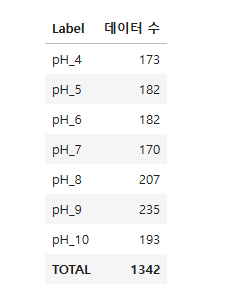
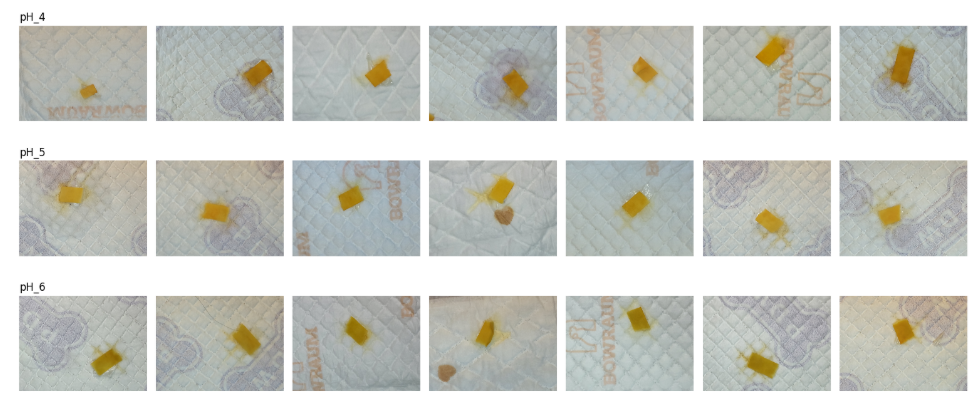
  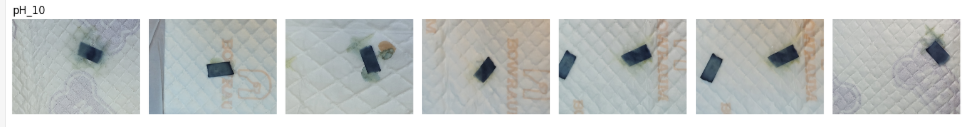

235

- 

### 1. 데이터 파악

In [1]:
# pH_data EDA (count / samples / resolution stats / simple duplicate check)
from pathlib import Path
from collections import Counter, defaultdict
import random, hashlib
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
ROOT = Path.cwd() / "pH_data"   
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
SAMPLE_PER_CLASS = 8
RANDOM_SEED = 42
DUP_CHECK_MAX_PER_CLASS = 5000  # 너무 많으면 느려질 수 있어서 상한

random.seed(RANDOM_SEED)

# =========================
# 1) Collect files
# =========================
assert ROOT.exists(), f"Not found: {ROOT}"

class_dirs = sorted([p for p in ROOT.iterdir() if p.is_dir() and p.name.lower().startswith("ph_")])
assert class_dirs, f"No class folders like pH_4~pH_10 found under {ROOT}"

rows = []
for cdir in class_dirs:
    label = cdir.name  # e.g., pH_4
    files = [p for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in EXTS]
    for fp in files:
        rows.append({"label": label, "path": str(fp)})

df = pd.DataFrame(rows)
display(df.head())

# =========================
# 2) Counts per class
# =========================
counts = df["label"].value_counts().sort_index()
print("=== Counts per class ===")
display(counts.to_frame("count"))
print(f"TOTAL: {len(df)}")

# =========================
# 3) Sample visualization
# =========================
def show_samples(df, per_class=SAMPLE_PER_CLASS, max_cols=8):
    labels = sorted(df["label"].unique())
    n_rows = len(labels)
    n_cols = min(per_class, max_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.2*n_rows))
    if n_rows == 1:
        axes = np.array([axes])
    for r, lab in enumerate(labels):
        sub = df[df["label"] == lab].sample(min(per_class, (df["label"]==lab).sum()), random_state=RANDOM_SEED)
        paths = sub["path"].tolist()
        for c in range(n_cols):
            ax = axes[r, c] if n_cols > 1 else axes[r, 0]
            ax.axis("off")
            if c < len(paths):
                img = Image.open(paths[c]).convert("RGB")
                ax.imshow(img)
                if c == 0:
                    ax.set_title(lab, fontsize=12, loc="left")
            else:
                if c == 0:
                    ax.set_title(lab, fontsize=12, loc="left")
    plt.tight_layout()
    plt.show()

show_samples(df)

# =========================
# 4) Resolution / aspect stats
# =========================
def get_img_size(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
        return w, h
    except Exception:
        return None, None

sizes = []
bad_files = []
for p in df["path"].tolist():
    w, h = get_img_size(p)
    if w is None:
        bad_files.append(p)
    else:
        sizes.append((w, h))

print(f"Unreadable files: {len(bad_files)}")
if bad_files:
    print("First 10 unreadable:")
    for x in bad_files[:10]:
        print(" -", x)

sizes_arr = np.array(sizes)
df_sizes = pd.DataFrame({
    "width": sizes_arr[:,0],
    "height": sizes_arr[:,1],
})
df_sizes["aspect"] = df_sizes["width"] / df_sizes["height"]

print("=== Resolution stats ===")
display(df_sizes.describe())

print("=== Top 15 most common resolutions ===")
res_counts = Counter([(int(w), int(h)) for w, h in sizes])
display(pd.DataFrame(res_counts.most_common(15), columns=["resolution", "count"]))

# =========================
# 5) Simple duplicate check (file hash)
#    - exact duplicates only (same bytes)
# =========================
def file_hash_md5(path, chunk=1024*1024):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            md5.update(b)
    return md5.hexdigest()

dup_map = defaultdict(list)
for lab in sorted(df["label"].unique()):
    sub = df[df["label"] == lab]["path"].tolist()
    sub = sub[:min(len(sub), DUP_CHECK_MAX_PER_CLASS)]
    for p in sub:
        try:
            h = file_hash_md5(p)
            dup_map[h].append(p)
        except Exception:
            pass

dups = {h: ps for h, ps in dup_map.items() if len(ps) > 1}
print(f"Exact duplicate groups: {len(dups)}")

if dups:
    # show a few duplicate groups
    print("=== Sample duplicate groups (up to 5) ===")
    for i, (h, ps) in enumerate(list(dups.items())[:5], 1):
        print(f"[Group {i}] md5={h}  count={len(ps)}")
        for p in ps[:10]:
            print("  -", p)
        if len(ps) > 10:
            print("  ...")

# =========================
# Optional: save summary csv
# =========================
summary = counts.reset_index()
summary.columns = ["label", "count"]
summary.to_csv(Path.cwd() / "ph_data_counts.csv", index=False, encoding="utf-8-sig")
print("Saved: ph_data_counts.csv")

AssertionError: Not found: D:\vibe_coding\llm_proj\pH_data

## 2. 데이터 분리(7:2:1)

In [3]:
# ============================================================
# 7:2:1 stratified split + TEST 봉인 코드
# - 원본 pH_data는 건드리지 않음
# - split_data/train, val, test 생성
# - test는 별도 폴더로 분리 (봉인)
# ============================================================

from pathlib import Path
import shutil
import random
from sklearn.model_selection import train_test_split

# =========================
# CONFIG
# =========================
RANDOM_SEED = 42
SRC_ROOT = Path.cwd() / "pH_data"
DST_ROOT = Path.cwd() / "split_data"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

random.seed(RANDOM_SEED)

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6

# =========================
# 폴더 준비
# =========================
for split in ["train", "val", "test"]:
    for class_dir in SRC_ROOT.iterdir():
        if class_dir.is_dir():
            (DST_ROOT / split / class_dir.name).mkdir(parents=True, exist_ok=True)

# =========================
# 클래스별 stratified split
# =========================
for class_dir in sorted([d for d in SRC_ROOT.iterdir() if d.is_dir()]):
    images = [
        p for p in class_dir.iterdir()
        if p.is_file() and p.suffix.lower() in EXTS
    ]

    assert len(images) > 0, f"No images in {class_dir.name}"

    # 1) train vs (val+test)
    train_imgs, temp_imgs = train_test_split(
        images,
        test_size=(1 - TRAIN_RATIO),
        random_state=RANDOM_SEED,
        shuffle=True
    )

    # 2) val vs test
    val_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        test_size=val_size,
        random_state=RANDOM_SEED,
        shuffle=True
    )

    # =========================
    # 파일 복사 (원본 보존)
    # =========================
    for p in train_imgs:
        shutil.copy2(p, DST_ROOT / "train" / class_dir.name / p.name)

    for p in val_imgs:
        shutil.copy2(p, DST_ROOT / "val" / class_dir.name / p.name)

    for p in test_imgs:
        shutil.copy2(p, DST_ROOT / "test" / class_dir.name / p.name)

    print(
        f"{class_dir.name}: "
        f"train={len(train_imgs)}, "
        f"val={len(val_imgs)}, "
        f"test={len(test_imgs)}"
    )

# =========================
# 완료 메시지
# =========================
print("\n✅ Split 완료")
print("📁 train/val → 학습·튜닝용")
print("🔒 test → 봉인 (최종 평가 전까지 사용 금지)")
# print(f"📍 경로: {DST_ROOT}")

pH_10: train=135, val=38, test=20
pH_4: train=121, val=34, test=18
pH_5: train=127, val=36, test=19
pH_6: train=127, val=36, test=19
pH_7: train=118, val=34, test=18
pH_8: train=144, val=42, test=21
pH_9: train=164, val=47, test=24

✅ Split 완료
📁 train/val → 학습·튜닝용
🔒 test → 봉인 (최종 평가 전까지 사용 금지)


## 3. 학습 파이프라인 구축

In [4]:
# ============================================================
# Step 1) Dataset / Dataloader / Transforms (minimal aug)
# ============================================================
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_ROOT = Path(r"데이터 폴더 경로")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"
TEST_DIR  = DATA_ROOT / "test"  # 봉인: 여기서는 사용하지 말 것

IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 0  # 윈도우 환경이면 0~4 사이에서 조절
SEED = 42

# ImageNet normalize
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),   # 최소 증강 (색 관련 증강 금지)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tf)
val_ds   = datasets.ImageFolder(str(VAL_DIR), transform=val_tf)

print("Class to idx:", train_ds.class_to_idx)
print("Train size:", len(train_ds), "Val size:", len(val_ds))

g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, generator=g
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

NUM_CLASSES = len(train_ds.classes)

Class to idx: {'pH_10': 0, 'pH_4': 1, 'pH_5': 2, 'pH_6': 3, 'pH_7': 4, 'pH_8': 5, 'pH_9': 6}
Train size: 936 Val size: 267


## 4. 모델 학습

In [5]:
# ============================================================
# Step 2) EfficientNet(v2_s) + Early Stopping (max 100 epochs)
# ============================================================
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.auto import tqdm
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

PIN_MEMORY = torch.cuda.is_available()

# dataloader (pin_memory 안전 적용)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, generator=g
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

# ---- MODEL ----
model = models.efficientnet_v2_s(
    weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
)
"""
EfficientNet_v2_s
├─ features        ← Conv blocks (백본 핵심)
├─ avgpool
└─ classifier
    ├─ [0] Dropout
    └─ [1] Linear(1280 → 1000)   ← ImageNet용 헤드
    
model.classifier[1] : Linear(1280 → 1000) # “1280차원 특징 벡터를 받아서 1000개 클래스 점수(logit)로 바꿔주는 완전연결층”이라는 뜻
ImageNet 1000 클래스 전용 사전학습된 태스크에 특화된 출력부
"""
# ---- Replace head ----
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ---- TRAIN SETUP ----
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ✅ EPOCHS는 scheduler보다 먼저 정의되어야 함
EPOCHS = 100
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# =========================
# ✅ Logging containers
# =========================
train_losses, val_losses = [], []
train_accs, val_accs = [], []
lrs = []

# =========================
# ✅ TensorBoard
# =========================
run_name = "effv2s_ft_lr1e-4_wd1e-4_cosine_es"
writer = SummaryWriter(log_dir=f"runs/{run_name}")


def run_one_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                loss.backward()
                optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += bs
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / total, correct / total


# ---- Early stopping ----
PATIENCE = 10
MIN_DELTA = 1e-4

best_val_loss = float("inf")
best_val_acc = 0.0
best_epoch = 0
early_stop_counter = 0

best_path = Path.cwd() / "best_efficientnet_ph.pt"

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc = run_one_epoch(model, val_loader, train=False)

    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # =========================
    # ✅ Save history (for matplotlib)
    # =========================
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    lrs.append(lr)

    # =========================
    # ✅ TensorBoard scalars
    # =========================
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Acc/train", train_acc, epoch)
    writer.add_scalar("Acc/val", val_acc, epoch)
    writer.add_scalar("LR", lr, epoch)

    print(
        f"[Epoch {epoch:03d}/{EPOCHS}] lr={lr:.2e} | "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} | "
        f"best_val_loss={best_val_loss:.4f} (epoch {best_epoch})"
    )

    # best model 저장 (val_loss 기준)
    if val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch
        early_stop_counter = 0

        torch.save(
            {
                "model_state": model.state_dict(),
                "class_to_idx": train_ds.class_to_idx,
                "img_size": IMG_SIZE,
                "backbone": "efficientnet_v2_s",
                "epoch": epoch,
                "val_loss": val_loss,
                "val_acc": val_acc,
            },
            best_path
        )
        print(f"  ✅ saved best (epoch={epoch}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f})")

    else:
        early_stop_counter += 1
        print(f"  ⏳ no improvement ({early_stop_counter}/{PATIENCE})")

        if early_stop_counter >= PATIENCE:
            print(f"\n🛑 Early stopping triggered at epoch {epoch}")
            break

print(f"\n✅ Training done. Best epoch={best_epoch}, best_val_loss={best_val_loss:.4f}, best_val_acc={best_val_acc:.4f}")
print(f"✅ Best checkpoint: {best_path}")

# =========================
# ✅ Close TensorBoard writer
# =========================
writer.close()

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 001/100] lr=1.00e-04 | train_loss=1.3136 train_acc=0.5449 | val_loss=0.6296 val_acc=0.7116 | best_val_loss=inf (epoch 0)
  ✅ saved best (epoch=1, val_loss=0.6296, val_acc=0.7116)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 002/100] lr=9.99e-05 | train_loss=0.4657 train_acc=0.8526 | val_loss=0.4126 val_acc=0.8390 | best_val_loss=0.6296 (epoch 1)
  ✅ saved best (epoch=2, val_loss=0.4126, val_acc=0.8390)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 003/100] lr=9.98e-05 | train_loss=0.2463 train_acc=0.9049 | val_loss=0.1503 val_acc=0.9513 | best_val_loss=0.4126 (epoch 2)
  ✅ saved best (epoch=3, val_loss=0.1503, val_acc=0.9513)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 004/100] lr=9.96e-05 | train_loss=0.1624 train_acc=0.9412 | val_loss=0.1288 val_acc=0.9625 | best_val_loss=0.1503 (epoch 3)
  ✅ saved best (epoch=4, val_loss=0.1288, val_acc=0.9625)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 005/100] lr=9.94e-05 | train_loss=0.1092 train_acc=0.9690 | val_loss=0.1422 val_acc=0.9625 | best_val_loss=0.1288 (epoch 4)
  ⏳ no improvement (1/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 006/100] lr=9.91e-05 | train_loss=0.0926 train_acc=0.9754 | val_loss=0.1445 val_acc=0.9551 | best_val_loss=0.1288 (epoch 4)
  ⏳ no improvement (2/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 007/100] lr=9.88e-05 | train_loss=0.1072 train_acc=0.9679 | val_loss=0.1200 val_acc=0.9625 | best_val_loss=0.1288 (epoch 4)
  ✅ saved best (epoch=7, val_loss=0.1200, val_acc=0.9625)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 008/100] lr=9.84e-05 | train_loss=0.0597 train_acc=0.9893 | val_loss=0.0896 val_acc=0.9775 | best_val_loss=0.1200 (epoch 7)
  ✅ saved best (epoch=8, val_loss=0.0896, val_acc=0.9775)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 009/100] lr=9.80e-05 | train_loss=0.0250 train_acc=0.9947 | val_loss=0.0934 val_acc=0.9775 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (1/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 010/100] lr=9.76e-05 | train_loss=0.0575 train_acc=0.9850 | val_loss=0.1293 val_acc=0.9700 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (2/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 011/100] lr=9.70e-05 | train_loss=0.0346 train_acc=0.9915 | val_loss=0.1570 val_acc=0.9513 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (3/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 012/100] lr=9.65e-05 | train_loss=0.0860 train_acc=0.9679 | val_loss=0.1115 val_acc=0.9625 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (4/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 013/100] lr=9.59e-05 | train_loss=0.0425 train_acc=0.9872 | val_loss=0.1082 val_acc=0.9625 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (5/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 014/100] lr=9.52e-05 | train_loss=0.0276 train_acc=0.9936 | val_loss=0.1449 val_acc=0.9588 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (6/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 015/100] lr=9.46e-05 | train_loss=0.0255 train_acc=0.9936 | val_loss=0.1462 val_acc=0.9663 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (7/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 016/100] lr=9.38e-05 | train_loss=0.0259 train_acc=0.9925 | val_loss=0.1565 val_acc=0.9551 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (8/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 017/100] lr=9.30e-05 | train_loss=0.0168 train_acc=0.9947 | val_loss=0.1895 val_acc=0.9625 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (9/10)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

[Epoch 018/100] lr=9.22e-05 | train_loss=0.0413 train_acc=0.9861 | val_loss=0.4141 val_acc=0.9101 | best_val_loss=0.0896 (epoch 8)
  ⏳ no improvement (10/10)

🛑 Early stopping triggered at epoch 18

✅ Training done. Best epoch=8, best_val_loss=0.0896, best_val_acc=0.9775
✅ Best checkpoint: D:\PyProject\pet_proj\best_efficientnet_ph.pt


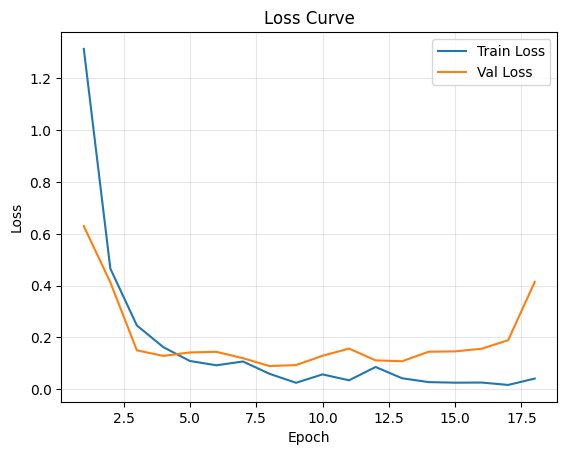

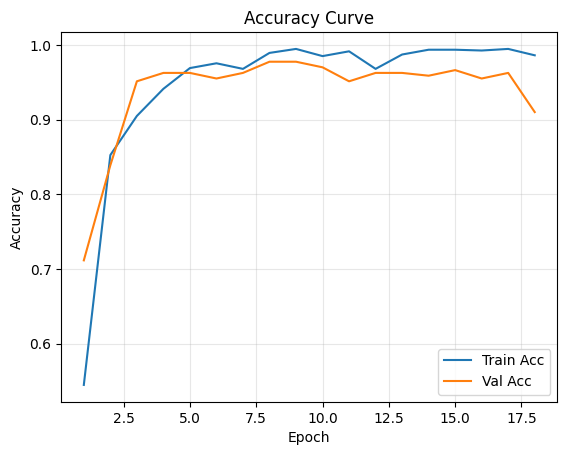

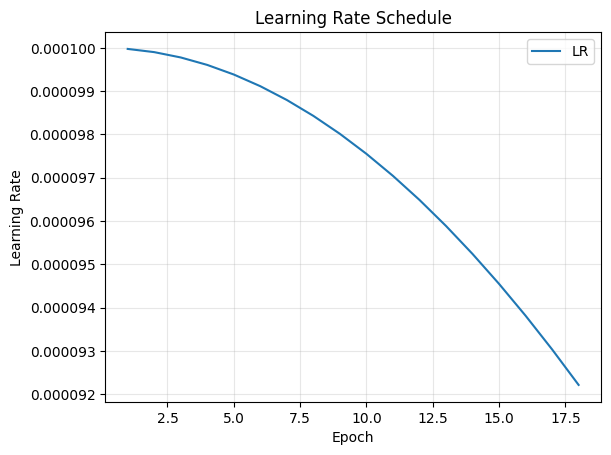

In [6]:
# =========================
# ✅ Matplotlib (separate figures per metric)
# =========================
epochs_range = range(1, len(train_losses) + 1)

# 1) Loss
plt.figure()
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2) Accuracy
plt.figure()
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3) Learning Rate
plt.figure()
plt.plot(epochs_range, lrs, label="LR")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
%load_ext tensorboard
%tensorboard --logdir runs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6424), started 0:05:24 ago. (Use '!kill 6424' to kill it.)

## 5. Evaluation

In [20]:
# ============================================================
# Step 3) VAL 평가: confusion matrix + top-2 가중평균 pH_hat + 신호등 지표
# + TensorBoard/Matplotlib 시각화
# (현재 창에서 train_ds, val_loader, DEVICE, NUM_CLASSES가 이미 정의되어 있다고 가정)
# ============================================================

# ✅ Train / Val / Test 역할
#  Train: 가중치 학습(optimizer가 업데이트)
# Val: 학습 중/후에 모델 선택·튜닝용 평가(Evaluation)
# Early stopping 기준, best checkpoint 선택, 하이퍼파라미터 결정 사실상 “개발(dev) 평가”
# Test: 모든 결정(모델/파라미터/기준)을 고정한 다음, 최종 성능 보고(정식 Test): “한 번만” 보는 게 원칙 (보고서/논문/제품 성능)

import os
import io
import glob
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

# ----------------------------
# 설정
# ----------------------------
# best_path = r"D:\PyProject\pet_proj\pH_First\best_efficientnet_ph.pt"
best_path = r"저장경로\best_efficientnet_ph.pt"
SPLIT_NAME = "VAL"   # "TEST" 로 바꾸고 loader만 test_loader로 바꾸면 정식 테스트로 사용 가능

# 신호등 기준(임시)
ACID_TH = 6.5
ALK_TH  = 8.0

# TensorBoard run 이름
eval_run_name = "eval_effv2s_best_on_val"

# ----------------------------
# 0) Best checkpoint 로드
# ----------------------------
ckpt = torch.load(best_path, map_location=DEVICE)
print("Loaded best:", best_path)
print("Backbone:", ckpt.get("backbone", "unknown"),
      "| Best epoch:", ckpt.get("epoch", "unknown"),
      "| val_loss:", ckpt.get("val_loss", "unknown"),
      "| val_acc:", ckpt.get("val_acc", "unknown"))

global_step = int(ckpt.get("epoch", 0))

# ----------------------------
# 1) 모델 재구성 + 로드
# ----------------------------
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model.load_state_dict(ckpt["model_state"])
model = model.to(DEVICE)
model.eval()

softmax = nn.Softmax(dim=1)

# ----------------------------
# 2) 클래스/pH 매핑 (안전 버전)
#   - ckpt["class_to_idx"]를 기준으로 idx -> class_name -> pH 구성
# ----------------------------
if "class_to_idx" in ckpt:
    class_to_idx = ckpt["class_to_idx"]
else:
    # 혹시 ckpt에 없으면(원래는 있음) train_ds 기준으로 fallback
    class_to_idx = train_ds.class_to_idx

idx_to_class = [None] * len(class_to_idx)
for cls_name, idx in class_to_idx.items():
    idx_to_class[idx] = cls_name

classes = idx_to_class  # index order 보장
ph_by_idx = np.array([float(c.split("_")[1]) for c in classes], dtype=np.float32)

print("Classes (idx order):", classes)
print("Class_to_idx used:", class_to_idx)

# ----------------------------
# 3) VAL inference
# ----------------------------
all_probs = []
all_y = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc=f"{SPLIT_NAME} inference"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        probs = softmax(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_y = np.concatenate(all_y, axis=0)
all_pred = all_probs.argmax(axis=1)

# ----------------------------
# 4-A) 정수 7-class 평가
# ----------------------------
cm = confusion_matrix(all_y, all_pred)
print(f"\n=== Confusion Matrix ({SPLIT_NAME}) ===")
print(cm)

print(f"\n=== Classification Report ({SPLIT_NAME}) ===")
print(classification_report(all_y, all_pred, target_names=classes, digits=4))

# ----------------------------
# 4-B) 실수 pH_hat (top-2 weighted)
# ----------------------------
def top2_weighted_ph(probs_row, ph_by_idx):
    idxs = np.argsort(probs_row)[-2:][::-1]
    i1, i2 = int(idxs[0]), int(idxs[1])
    p1, p2 = float(probs_row[i1]), float(probs_row[i2])
    ph1, ph2 = float(ph_by_idx[i1]), float(ph_by_idx[i2])
    return (p1 * ph1 + p2 * ph2) / (p1 + p2 + 1e-12)

ph_hat = np.array([top2_weighted_ph(r, ph_by_idx) for r in all_probs], dtype=np.float32)
y_ph   = ph_by_idx[all_y]

abs_err = np.abs(ph_hat - y_ph)
err = ph_hat - y_ph

mae = float(np.mean(abs_err))
acc_05 = float(np.mean(abs_err <= 0.5))
acc_10 = float(np.mean(abs_err <= 1.0))

print(f"\n=== Real-valued pH metrics ({SPLIT_NAME}, top-2 weighted) ===")
print(f"MAE: {mae:.4f}")
print(f"Within ±0.5: {acc_05:.4f}")
print(f"Within ±1.0: {acc_10:.4f}")
print(f"pH_hat range: {ph_hat.min():.2f} ~ {ph_hat.max():.2f}")

# ----------------------------
# 4-C) 신호등 지표
# ----------------------------
acid_pred = ph_hat <= ACID_TH
alk_pred  = ph_hat >= ALK_TH
norm_pred = (~acid_pred) & (~alk_pred)

acid_true = y_ph <= ACID_TH
alk_true  = y_ph >= ALK_TH
norm_true = (~acid_true) & (~alk_true)

def recall(pred_mask, true_mask):
    tp = np.sum(pred_mask & true_mask)
    fn = np.sum((~pred_mask) & true_mask)
    return float(tp / (tp + fn + 1e-12)), int(tp), int(fn)

acid_recall, acid_tp, acid_fn = recall(acid_pred, acid_true)
alk_recall,  alk_tp,  alk_fn  = recall(alk_pred,  alk_true)

print(f"\n=== Traffic Light ({SPLIT_NAME}) ===")
print(f"Acid recall (<= {ACID_TH}): {acid_recall:.4f} (TP={acid_tp}, FN={acid_fn})")
print(f"Alk  recall (>= {ALK_TH}): {alk_recall:.4f} (TP={alk_tp}, FN={alk_fn})")
print(f"Pred counts: acid={int(acid_pred.sum())}, normal={int(norm_pred.sum())}, alk={int(alk_pred.sum())}")
print(f"True  counts: acid={int(acid_true.sum())}, normal={int(norm_true.sum())}, alk={int(alk_true.sum())}")

Loaded best: D:\PyProject\pet_proj\best_efficientnet_ph.pt
Backbone: efficientnet_v2_s | Best epoch: 8 | val_loss: 0.08959455015870292 | val_acc: 0.9775280898876404
Classes (idx order): ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']
Class_to_idx used: {'pH_10': 0, 'pH_4': 1, 'pH_5': 2, 'pH_6': 3, 'pH_7': 4, 'pH_8': 5, 'pH_9': 6}


VAL inference:   0%|          | 0/17 [00:00<?, ?it/s]


=== Confusion Matrix (VAL) ===
[[38  0  0  0  0  0  0]
 [ 1 31  2  0  0  0  0]
 [ 0  1 34  1  0  0  0]
 [ 0  0  1 35  0  0  0]
 [ 0  0  0  0 34  0  0]
 [ 0  0  0  0  0 42  0]
 [ 0  0  0  0  0  0 47]]

=== Classification Report (VAL) ===
              precision    recall  f1-score   support

       pH_10     0.9744    1.0000    0.9870        38
        pH_4     0.9688    0.9118    0.9394        34
        pH_5     0.9189    0.9444    0.9315        36
        pH_6     0.9722    0.9722    0.9722        36
        pH_7     1.0000    1.0000    1.0000        34
        pH_8     1.0000    1.0000    1.0000        42
        pH_9     1.0000    1.0000    1.0000        47

    accuracy                         0.9775       267
   macro avg     0.9763    0.9755    0.9757       267
weighted avg     0.9777    0.9775    0.9775       267


=== Real-valued pH metrics (VAL, top-2 weighted) ===
MAE: 0.0506
Within ±0.5: 0.9775
Within ±1.0: 0.9888
pH_hat range: 4.00 ~ 10.00

=== Traffic Light (VAL) ===
Aci

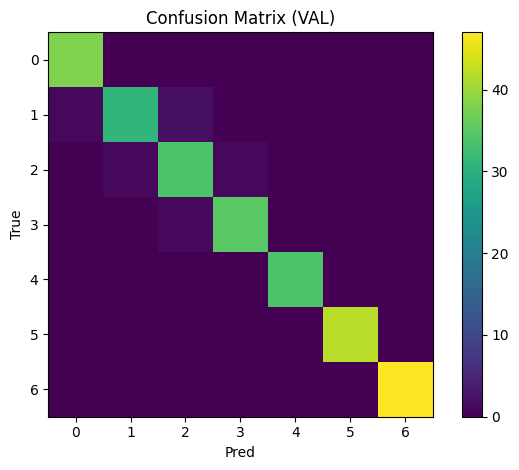

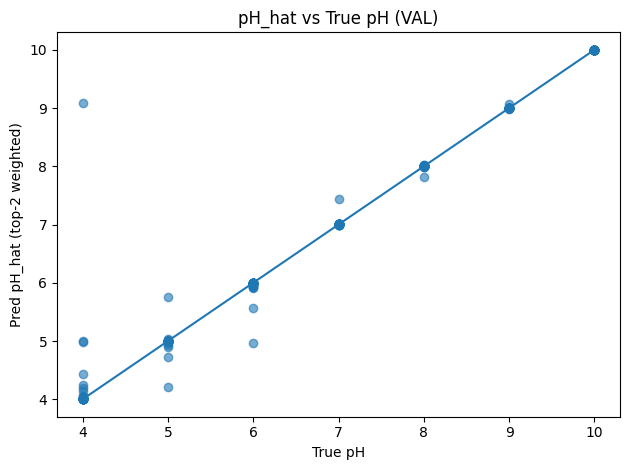

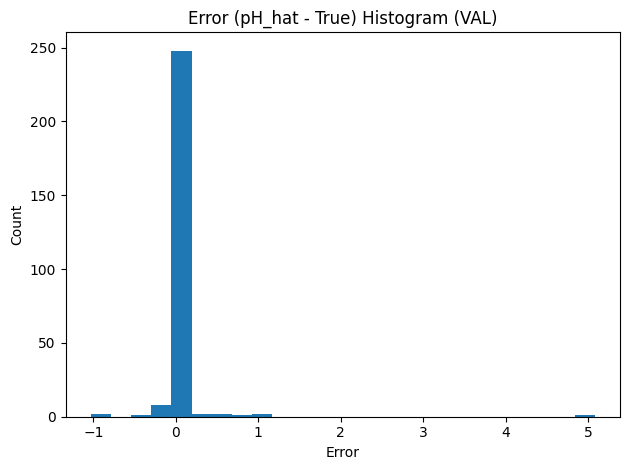

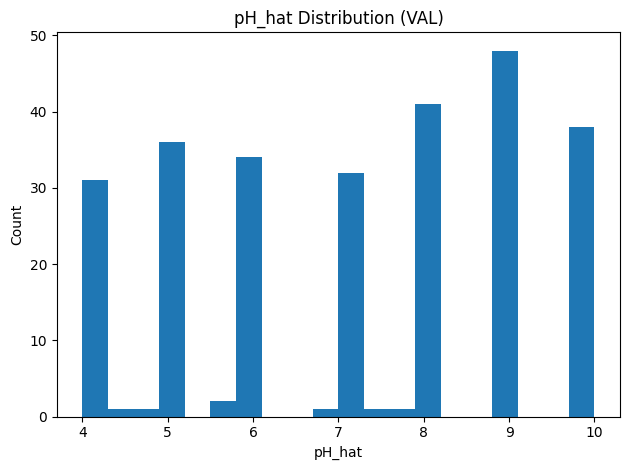

In [22]:
# ============================================================
# 5) Matplotlib 시각화 (각각 별도 figure)
# ============================================================

# (1) Confusion Matrix heatmap (간단 버전)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix ({SPLIT_NAME})")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# (2) pH_hat vs y_ph (scatter)
plt.figure()
plt.scatter(y_ph, ph_hat, alpha=0.6)
plt.plot([y_ph.min(), y_ph.max()], [y_ph.min(), y_ph.max()])  # y=x
plt.title(f"pH_hat vs True pH ({SPLIT_NAME})")
plt.xlabel("True pH")
plt.ylabel("Pred pH_hat (top-2 weighted)")
plt.tight_layout()
plt.show()

# (3) Error histogram
plt.figure()
plt.hist(err, bins=25)
plt.title(f"Error (pH_hat - True) Histogram ({SPLIT_NAME})")
plt.xlabel("Error")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# (4) pH_hat distribution
plt.figure()
plt.hist(ph_hat, bins=20)
plt.title(f"pH_hat Distribution ({SPLIT_NAME})")
plt.xlabel("pH_hat")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [24]:
# ============================================================
# 6) TensorBoard 로깅
# ============================================================
writer = SummaryWriter(log_dir=f"runs/{eval_run_name}")

# ---- Scalars ----
writer.add_scalar(f"{SPLIT_NAME}/MAE_top2", mae, global_step)
writer.add_scalar(f"{SPLIT_NAME}/Within_0.5", acc_05, global_step)
writer.add_scalar(f"{SPLIT_NAME}/Within_1.0", acc_10, global_step)

writer.add_scalar(f"{SPLIT_NAME}/TrafficLight_Acid_recall", acid_recall, global_step)
writer.add_scalar(f"{SPLIT_NAME}/TrafficLight_Alk_recall",  alk_recall,  global_step)

# ---- Confusion Matrix image ----
fig = plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix ({SPLIT_NAME})")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()

buf = io.BytesIO()
fig.savefig(buf, format="png", dpi=150)
plt.close(fig)
buf.seek(0)

img = Image.open(buf).convert("RGB")
img_np = np.array(img)
writer.add_image(f"{SPLIT_NAME}/ConfusionMatrix", img_np, global_step=global_step, dataformats="HWC")

# ---- Histograms ----
writer.add_histogram(f"{SPLIT_NAME}/pH_hat", ph_hat, global_step)
writer.add_histogram(f"{SPLIT_NAME}/error", err, global_step)

writer.close()

print(f"\n✅ TensorBoard logged to: runs/{eval_run_name}")
print("✅ Done.")


✅ TensorBoard logged to: runs/eval_effv2s_best_on_val
✅ Done.


In [26]:
tensorboard --logdir=runs

## 6. Test 

In [23]:
# ============================================================
# FINAL EVAL (TEST) — 봉인 해제 1회 평가
# 1) 7-class confusion matrix + report
# 2) Traffic Light(정수 Top-1): acid(4,5) / yellow(6,8) / normal(7) / alk(9,10)
# ============================================================

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

# ---- paths (필요시 수정) ----
DATA_ROOT = Path(r"분리된 데이터 저장경로")
TEST_DIR  = DATA_ROOT / "test"

BEST_PATH = Path(r"모델 저장경로\best_efficientnet_ph.pt")

# ---- device ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# ---- transforms (val/test는 동일) ----
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ---- test dataset/loader ----
test_ds = datasets.ImageFolder(str(TEST_DIR), transform=test_tf)
print("TEST classes:", test_ds.classes)
print("TEST class_to_idx:", test_ds.class_to_idx)
print("TEST size:", len(test_ds))

BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

NUM_CLASSES = len(test_ds.classes)

# ---- load ckpt ----
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
print("Loaded best:", BEST_PATH)
print("Backbone:", ckpt.get("backbone", "unknown"),
      "| Epoch:", ckpt.get("epoch", "unknown"),
      "| val_loss:", ckpt.get("val_loss", "unknown"),
      "| val_acc:", ckpt.get("val_acc", "unknown"))

# ---- build model (match training backbone) ----
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model.load_state_dict(ckpt["model_state"])
model = model.to(DEVICE)
model.eval()

softmax = nn.Softmax(dim=1)

all_probs = []
all_y = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="TEST inference"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        probs = softmax(logits).cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_y = np.concatenate(all_y, axis=0)
all_pred = all_probs.argmax(axis=1)

classes = test_ds.classes  # 평가 기준 클래스 순서(폴더명 알파벳 정렬)
print("\n=== 7-class (TEST) ===")
cm = confusion_matrix(all_y, all_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_y, all_pred, target_names=classes, digits=4))

# ============================================================
# Traffic Light (정수 Top-1 기반 정책)
# 산성: 4,5 / 경계(노란불): 6,8 / 정상: 7 / 알칼리: 9,10
# ============================================================

ph_by_idx = np.array([int(c.split("_")[1]) for c in classes], dtype=int)
y_ph_int = ph_by_idx[all_y]
p_ph_int = ph_by_idx[all_pred]

def traffic_label(ph_int):
    # 0: 산성(빨강), 1: 경계(노랑), 2: 정상(초록), 3: 알칼리(빨강)
    if ph_int in (4, 5):
        return 0
    if ph_int in (6, 8):
        return 1
    if ph_int == 7:
        return 2
    if ph_int in (9, 10):
        return 3
    raise ValueError(f"Unexpected pH: {ph_int}")

y_tl = np.array([traffic_label(v) for v in y_ph_int], dtype=int)
p_tl = np.array([traffic_label(v) for v in p_ph_int], dtype=int)

tl_names = ["acid_red(4,5)", "yellow(6,8)", "normal_green(7)", "alk_red(9,10)"]

cm_tl = confusion_matrix(y_tl, p_tl)
print("\n=== Traffic Light Confusion Matrix (TEST) ===")
print(cm_tl)

print("\n=== Traffic Light Report (TEST) ===")
print(classification_report(y_tl, p_tl, target_names=tl_names, digits=4))

acid_recall = cm_tl[0,0] / (cm_tl[0,:].sum() + 1e-12)
alk_recall  = cm_tl[3,3] / (cm_tl[3,:].sum() + 1e-12)
print(f"\nAcid(red 4,5) recall: {acid_recall:.4f}")
print(f"Alk (red 9,10) recall: {alk_recall:.4f}")

unique, counts = np.unique(y_tl, return_counts=True)
print("\nTrue traffic-light counts:", {tl_names[u]: int(c) for u, c in zip(unique, counts)})
unique, counts = np.unique(p_tl, return_counts=True)
print("Pred traffic-light counts:", {tl_names[u]: int(c) for u, c in zip(unique, counts)})

DEVICE: cuda
TEST classes: ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']
TEST class_to_idx: {'pH_10': 0, 'pH_4': 1, 'pH_5': 2, 'pH_6': 3, 'pH_7': 4, 'pH_8': 5, 'pH_9': 6}
TEST size: 139
Loaded best: D:\PyProject\pet_proj\pH_First\best_efficientnet_ph.pt
Backbone: efficientnet_v2_s | Epoch: 8 | val_loss: 0.08959455015870292 | val_acc: 0.9775280898876404


TEST inference:   0%|          | 0/9 [00:00<?, ?it/s]


=== 7-class (TEST) ===
Confusion Matrix:
 [[20  0  0  0  0  0  0]
 [ 0 15  3  0  0  0  0]
 [ 0  2 17  0  0  0  0]
 [ 0  0  0 19  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

       pH_10     1.0000    1.0000    1.0000        20
        pH_4     0.8824    0.8333    0.8571        18
        pH_5     0.8500    0.8947    0.8718        19
        pH_6     1.0000    1.0000    1.0000        19
        pH_7     1.0000    1.0000    1.0000        18
        pH_8     1.0000    1.0000    1.0000        21
        pH_9     1.0000    1.0000    1.0000        24

    accuracy                         0.9640       139
   macro avg     0.9618    0.9612    0.9613       139
weighted avg     0.9643    0.9640    0.9640       139


=== Traffic Light Confusion Matrix (TEST) ===
[[37  0  0  0]
 [ 0 40  0  0]
 [ 0  0 18  0]
 [ 0  0  0 44]]

=== Traffic Light Report (TEST) ===
                 prec

In [30]:
# ============================================================
# FINAL EVAL (TEST) — 봉인 해제 1회 평가
# 1) 7-class confusion matrix + report
# 2) Traffic Light(정수 Top-1): acid(4,5) / yellow(6,8) / normal(7) / alk(9,10)
#
# ✅ 경로 자동화:
# - BEST_PATH: 현재 CWD 기준으로 best_efficientnet_ph.pt 자동 탐색
# - DATA_ROOT: 사용자 환경에 맞춰 split_data 경로 지정 (필요시 수정)
# ============================================================

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

# ----------------------------
# 0) Paths
# ----------------------------
# ✅ split_data 경로만 맞추면 됩니다 (test 폴더가 그 아래에 있어야 함)
DATA_ROOT = Path(r"분리된 데이터 저장 경로")
TEST_DIR  = DATA_ROOT / "test"

# ✅ best 체크포인트 자동 탐색: 현재 작업 폴더(CWD)에서 먼저 찾고, 없으면 프로젝트 내에서 재귀 탐색
def find_best_ckpt(filename="best_efficientnet_ph.pt"):
    cwd_path = Path.cwd() / filename
    if cwd_path.exists():
        return cwd_path

    # 프로젝트 폴더 아래에서 찾기 (너무 넓으면 느릴 수 있으니 필요시 검색 범위를 좁히세요)
    hits = list(Path.cwd().rglob(filename))
    if len(hits) > 0:
        return hits[0]

    raise FileNotFoundError(
        f"Cannot find '{filename}'.\n"
        f"- Tried: {cwd_path}\n"
        f"- Tried: recursive search under {Path.cwd()}\n"
        f"→ best 모델 파일 경로를 BEST_PATH로 직접 지정해 주세요."
    )

BEST_PATH = find_best_ckpt("best_efficientnet_ph.pt")
print("✅ BEST_PATH:", BEST_PATH)

# ----------------------------
# 1) Device
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# ----------------------------
# 2) Transforms (val/test 동일)
# ----------------------------
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ----------------------------
# 3) Test dataset/loader
# ----------------------------
if not TEST_DIR.exists():
    raise FileNotFoundError(f"TEST_DIR not found: {TEST_DIR}")

test_ds = datasets.ImageFolder(str(TEST_DIR), transform=test_tf)
print("TEST classes (folder order):", test_ds.classes)
print("TEST class_to_idx:", test_ds.class_to_idx)
print("TEST size:", len(test_ds))

BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

NUM_CLASSES = len(test_ds.classes)

# ----------------------------
# 4) Load ckpt
# ----------------------------
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
print("Loaded best:", BEST_PATH)
print("Backbone:", ckpt.get("backbone", "unknown"),
      "| Epoch:", ckpt.get("epoch", "unknown"),
      "| val_loss:", ckpt.get("val_loss", "unknown"),
      "| val_acc:", ckpt.get("val_acc", "unknown"))

# ----------------------------
# 5) Class order alignment (중요)
# - ckpt["class_to_idx"] 기준으로 idx->class를 확정
# - test_ds의 라벨 인덱스가 같은 의미를 가지는지 확인 필요
#   (일반적으로 ImageFolder는 폴더명 알파벳 순이라 train/val/test 모두 같으면 OK)
# ----------------------------
if "class_to_idx" in ckpt:
    ckpt_class_to_idx = ckpt["class_to_idx"]
    # ckpt 인덱스 순서로 classes 만들기
    idx_to_class = [None] * len(ckpt_class_to_idx)
    for cls_name, idx in ckpt_class_to_idx.items():
        idx_to_class[idx] = cls_name
    classes = idx_to_class
else:
    # fallback: test 폴더 기준
    classes = test_ds.classes

# 안전 점검(폴더 class_to_idx와 ckpt class_to_idx가 다른 경우 경고)
if "class_to_idx" in ckpt:
    if ckpt_class_to_idx != test_ds.class_to_idx:
        print("\n⚠️ WARNING: ckpt class_to_idx != test_ds class_to_idx")
        print("ckpt :", ckpt_class_to_idx)
        print("test :", test_ds.class_to_idx)
        print("→ train/val/test 폴더명이 동일한지, 정렬/구조가 같은지 확인하세요.\n")

print("EVAL classes (used for reporting):", classes)

# ----------------------------
# 6) Build model (match training backbone)
# ----------------------------
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model.load_state_dict(ckpt["model_state"])
model = model.to(DEVICE)
model.eval()

softmax = nn.Softmax(dim=1)

# ----------------------------
# 7) TEST inference
# ----------------------------
all_probs = []
all_y = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="TEST inference"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        probs = softmax(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_y = np.concatenate(all_y, axis=0)
all_pred = all_probs.argmax(axis=1)

# ----------------------------
# 8) 7-class metrics (TEST)
# ----------------------------
print("\n=== 7-class (TEST) ===")
cm = confusion_matrix(all_y, all_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(all_y, all_pred, target_names=classes, digits=4))

# ============================================================
# 9) Traffic Light (정수 Top-1 기반 정책)
# 산성: 4,5 / 경계(노란불): 6,8 / 정상: 7 / 알칼리: 9,10
# ============================================================

ph_by_idx = np.array([int(c.split("_")[1]) for c in classes], dtype=int)
y_ph_int = ph_by_idx[all_y]
p_ph_int = ph_by_idx[all_pred]

def traffic_label(ph_int):
    # 0: 산성(빨강), 1: 경계(노랑), 2: 정상(초록), 3: 알칼리(빨강)
    if ph_int in (4, 5):
        return 0
    if ph_int in (6, 8):
        return 1
    if ph_int == 7:
        return 2
    if ph_int in (9, 10):
        return 3
    raise ValueError(f"Unexpected pH: {ph_int}")

y_tl = np.array([traffic_label(v) for v in y_ph_int], dtype=int)
p_tl = np.array([traffic_label(v) for v in p_ph_int], dtype=int)

tl_names = ["acid_red(4,5)", "yellow(6,8)", "normal_green(7)", "alk_red(9,10)"]

cm_tl = confusion_matrix(y_tl, p_tl)
print("\n=== Traffic Light Confusion Matrix (TEST) ===")
print(cm_tl)

print("\n=== Traffic Light Report (TEST) ===")
print(classification_report(y_tl, p_tl, target_names=tl_names, digits=4))

acid_recall = cm_tl[0, 0] / (cm_tl[0, :].sum() + 1e-12)
alk_recall  = cm_tl[3, 3] / (cm_tl[3, :].sum() + 1e-12)
print(f"\nAcid(red 4,5) recall: {acid_recall:.4f}")
print(f"Alk (red 9,10) recall: {alk_recall:.4f}")

unique, counts = np.unique(y_tl, return_counts=True)
print("\nTrue traffic-light counts:", {tl_names[u]: int(c) for u, c in zip(unique, counts)})

unique, counts = np.unique(p_tl, return_counts=True)
print("Pred traffic-light counts:", {tl_names[u]: int(c) for u, c in zip(unique, counts)})


✅ BEST_PATH: D:\PyProject\pet_proj\best_efficientnet_ph.pt
DEVICE: cuda
TEST classes (folder order): ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']
TEST class_to_idx: {'pH_10': 0, 'pH_4': 1, 'pH_5': 2, 'pH_6': 3, 'pH_7': 4, 'pH_8': 5, 'pH_9': 6}
TEST size: 139
Loaded best: D:\PyProject\pet_proj\best_efficientnet_ph.pt
Backbone: efficientnet_v2_s | Epoch: 8 | val_loss: 0.08959455015870292 | val_acc: 0.9775280898876404
EVAL classes (used for reporting): ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']


TEST inference:   0%|          | 0/9 [00:00<?, ?it/s]


=== 7-class (TEST) ===
Confusion Matrix:
 [[20  0  0  0  0  0  0]
 [ 0 15  3  0  0  0  0]
 [ 0  2 17  0  0  0  0]
 [ 0  0  0 19  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

       pH_10     1.0000    1.0000    1.0000        20
        pH_4     0.8824    0.8333    0.8571        18
        pH_5     0.8500    0.8947    0.8718        19
        pH_6     1.0000    1.0000    1.0000        19
        pH_7     1.0000    1.0000    1.0000        18
        pH_8     1.0000    1.0000    1.0000        21
        pH_9     1.0000    1.0000    1.0000        24

    accuracy                         0.9640       139
   macro avg     0.9618    0.9612    0.9613       139
weighted avg     0.9643    0.9640    0.9640       139


=== Traffic Light Confusion Matrix (TEST) ===
[[37  0  0  0]
 [ 0 40  0  0]
 [ 0  0 18  0]
 [ 0  0  0 44]]

=== Traffic Light Report (TEST) ===
                 prec

✅ BEST_PATH: D:\PyProject\pet_proj\best_efficientnet_ph.pt
DEVICE: cuda
TEST classes (folder order): ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']
TEST class_to_idx: {'pH_10': 0, 'pH_4': 1, 'pH_5': 2, 'pH_6': 3, 'pH_7': 4, 'pH_8': 5, 'pH_9': 6}
TEST size: 139
Loaded best: D:\PyProject\pet_proj\best_efficientnet_ph.pt
Backbone: efficientnet_v2_s | Epoch: 8 | val_loss: 0.08959455015870292 | val_acc: 0.9775280898876404
EVAL classes (used for reporting): ['pH_10', 'pH_4', 'pH_5', 'pH_6', 'pH_7', 'pH_8', 'pH_9']


TEST inference:   0%|          | 0/9 [00:00<?, ?it/s]


=== 7-class (TEST) ===
Confusion Matrix:
 [[20  0  0  0  0  0  0]
 [ 0 15  3  0  0  0  0]
 [ 0  2 17  0  0  0  0]
 [ 0  0  0 19  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

       pH_10     1.0000    1.0000    1.0000        20
        pH_4     0.8824    0.8333    0.8571        18
        pH_5     0.8500    0.8947    0.8718        19
        pH_6     1.0000    1.0000    1.0000        19
        pH_7     1.0000    1.0000    1.0000        18
        pH_8     1.0000    1.0000    1.0000        21
        pH_9     1.0000    1.0000    1.0000        24

    accuracy                         0.9640       139
   macro avg     0.9618    0.9612    0.9613       139
weighted avg     0.9643    0.9640    0.9640       139


=== Traffic Light Confusion Matrix (TEST) ===
[[37  0  0  0]
 [ 0 40  0  0]
 [ 0  0 18  0]
 [ 0  0  0 44]]

=== Traffic Light Report (TEST) ===
                 prec

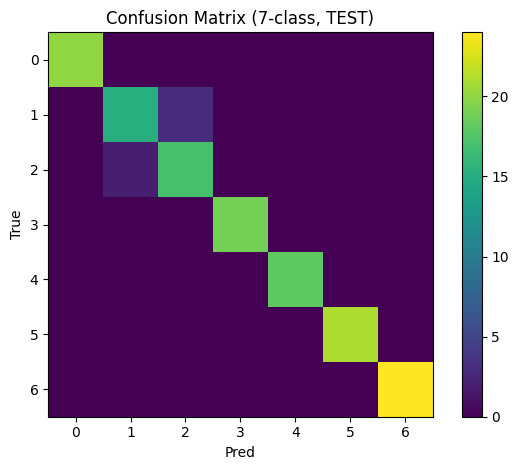

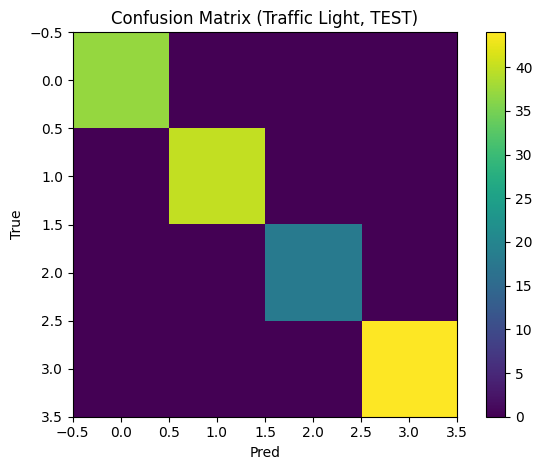

In [32]:
# ============================================================
# FINAL EVAL (TEST) — 봉인 해제 1회 평가
# + Matplotlib & TensorBoard Logging
# 1) 7-class confusion matrix + report
# 2) Traffic Light(정수 Top-1): acid(4,5) / yellow(6,8) / normal(7) / alk(9,10)
# ============================================================

from pathlib import Path
import os
import io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

# ----------------------------
# 0) Paths
# ----------------------------
DATA_ROOT = Path(r"분리된 데이터 저장경로")
TEST_DIR  = DATA_ROOT / "test"

def find_best_ckpt(filename="best_efficientnet_ph.pt"):
    cwd_path = Path.cwd() / filename
    if cwd_path.exists():
        return cwd_path
    hits = list(Path.cwd().rglob(filename))
    if len(hits) > 0:
        return hits[0]
    raise FileNotFoundError(
        f"Cannot find '{filename}'.\n"
        f"- Tried: {cwd_path}\n"
        f"- Tried: recursive search under {Path.cwd()}\n"
        f"→ best 모델 파일 경로를 BEST_PATH로 직접 지정해 주세요."
    )

BEST_PATH = find_best_ckpt("best_efficientnet_ph.pt")
print("✅ BEST_PATH:", BEST_PATH)

# TensorBoard run 이름(최종평가 전용)
tb_run_name = "FINAL_TEST_effv2s_best"
writer = SummaryWriter(log_dir=f"runs/{tb_run_name}")

# ----------------------------
# 1) Device
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# ----------------------------
# 2) Transforms
# ----------------------------
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ----------------------------
# 3) Test dataset/loader
# ----------------------------
if not TEST_DIR.exists():
    raise FileNotFoundError(f"TEST_DIR not found: {TEST_DIR}")

test_ds = datasets.ImageFolder(str(TEST_DIR), transform=test_tf)
print("TEST classes (folder order):", test_ds.classes)
print("TEST class_to_idx:", test_ds.class_to_idx)
print("TEST size:", len(test_ds))

BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

NUM_CLASSES = len(test_ds.classes)

# ----------------------------
# 4) Load ckpt
# ----------------------------
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
print("Loaded best:", BEST_PATH)
print("Backbone:", ckpt.get("backbone", "unknown"),
      "| Epoch:", ckpt.get("epoch", "unknown"),
      "| val_loss:", ckpt.get("val_loss", "unknown"),
      "| val_acc:", ckpt.get("val_acc", "unknown"))

global_step = int(ckpt.get("epoch", 0))

# ----------------------------
# 5) Class order alignment (중요)
# ----------------------------
if "class_to_idx" in ckpt:
    ckpt_class_to_idx = ckpt["class_to_idx"]
    idx_to_class = [None] * len(ckpt_class_to_idx)
    for cls_name, idx in ckpt_class_to_idx.items():
        idx_to_class[idx] = cls_name
    classes = idx_to_class
else:
    classes = test_ds.classes

if "class_to_idx" in ckpt and ckpt_class_to_idx != test_ds.class_to_idx:
    print("\n⚠️ WARNING: ckpt class_to_idx != test_ds class_to_idx")
    print("ckpt :", ckpt_class_to_idx)
    print("test :", test_ds.class_to_idx)
    print("→ train/val/test 폴더명/정렬/구조가 동일한지 확인하세요.\n")

print("EVAL classes (used for reporting):", classes)

# ----------------------------
# 6) Build model
# ----------------------------
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model.load_state_dict(ckpt["model_state"])
model = model.to(DEVICE)
model.eval()

softmax = nn.Softmax(dim=1)

# ----------------------------
# 7) TEST inference
# ----------------------------
all_probs = []
all_y = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="TEST inference"):
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        probs = softmax(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_y = np.concatenate(all_y, axis=0)
all_pred = all_probs.argmax(axis=1)

# ----------------------------
# 8) 7-class metrics
# ----------------------------
print("\n=== 7-class (TEST) ===")
cm7 = confusion_matrix(all_y, all_pred)
print("Confusion Matrix:\n", cm7)
print("\nClassification Report:\n",
      classification_report(all_y, all_pred, target_names=classes, digits=4))

# ============================================================
# 9) Traffic Light (정수 Top-1 기반 정책)
# 산성: 4,5 / 경계(노란불): 6,8 / 정상: 7 / 알칼리: 9,10
# ============================================================
ph_by_idx = np.array([int(c.split("_")[1]) for c in classes], dtype=int)
y_ph_int = ph_by_idx[all_y]
p_ph_int = ph_by_idx[all_pred]

def traffic_label(ph_int):
    # 0: 산성(빨강), 1: 경계(노랑), 2: 정상(초록), 3: 알칼리(빨강)
    if ph_int in (4, 5):
        return 0
    if ph_int in (6, 8):
        return 1
    if ph_int == 7:
        return 2
    if ph_int in (9, 10):
        return 3
    raise ValueError(f"Unexpected pH: {ph_int}")

y_tl = np.array([traffic_label(v) for v in y_ph_int], dtype=int)
p_tl = np.array([traffic_label(v) for v in p_ph_int], dtype=int)

tl_names = ["acid_red(4,5)", "yellow(6,8)", "normal_green(7)", "alk_red(9,10)"]

cm_tl = confusion_matrix(y_tl, p_tl)
print("\n=== Traffic Light Confusion Matrix (TEST) ===")
print(cm_tl)

print("\n=== Traffic Light Report (TEST) ===")
print(classification_report(y_tl, p_tl, target_names=tl_names, digits=4))

acid_recall = cm_tl[0, 0] / (cm_tl[0, :].sum() + 1e-12)
alk_recall  = cm_tl[3, 3] / (cm_tl[3, :].sum() + 1e-12)
print(f"\nAcid(red 4,5) recall: {acid_recall:.4f}")
print(f"Alk (red 9,10) recall: {alk_recall:.4f}")

# ----------------------------
# 10) Matplotlib: Confusion Matrix figures (2개 별도)
# ----------------------------
# (A) 7-class CM
plt.figure()
plt.imshow(cm7, interpolation="nearest")
plt.title("Confusion Matrix (7-class, TEST)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# (B) Traffic Light CM
plt.figure()
plt.imshow(cm_tl, interpolation="nearest")
plt.title("Confusion Matrix (Traffic Light, TEST)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

In [33]:
# ----------------------------
# 11) TensorBoard logging
# ----------------------------
# Scalars
writer.add_scalar("TEST/TrafficLight_Acid_recall", float(acid_recall), global_step)
writer.add_scalar("TEST/TrafficLight_Alk_recall",  float(alk_recall),  global_step)

# Helper: figure -> TensorBoard image
def fig_to_tb_image(fig, tag, step):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=150)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    img_np = np.array(img)
    writer.add_image(tag, img_np, step, dataformats="HWC")

# 7-class CM figure -> TB image
fig7 = plt.figure()
plt.imshow(cm7, interpolation="nearest")
plt.title("Confusion Matrix (7-class, TEST)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
fig_to_tb_image(fig7, "TEST/ConfusionMatrix_7class", global_step)

# Traffic Light CM figure -> TB image
figtl = plt.figure()
plt.imshow(cm_tl, interpolation="nearest")
plt.title("Confusion Matrix (Traffic Light, TEST)")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
fig_to_tb_image(figtl, "TEST/ConfusionMatrix_TrafficLight", global_step)

writer.close()
print(f"\n✅ TensorBoard logged to: runs/{tb_run_name}")
print("✅ Done.")


✅ TensorBoard logged to: runs/FINAL_TEST_effv2s_best
✅ Done.


In [36]:
tensorboard --logdir runs